In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Find calibrators near Eta Crv

First, some imports!

In [3]:
import sys, os
from all_sky_target_tool import list_builder as lb
from all_sky_target_tool import import target_tools as tt
from all_sky_target_tool import import availability_checker as ac
from all_sky_target_tool import import sort_targets as st
from all_sky_target_tool import import write_gallery as wg
import datetime
import glob
import numpy as np
import astropy.table as at
import astropy.units as q
import astropy.io.ascii as ii
import astropy.coordinates as coords
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from astroquery.irsa import Irsa
from astroquery.vizier import Vizier
from astroquery.simbad import Simbad

ImportError: cannot import name 'list_builder'

This is a general recipe on how to find calibrator stars near my targets.

First, I'll store the search criteria in some variables. 

In [64]:
# if float: The allowed magnitude difference from the target K magnitude
# if tuple: The upper and lower K magnitude values (in case of asymmetry)
#delta_K = (3.4, 4.5)
delta_K = 2.                      

# The allowed color difference from the target
delta_color = 2.

# The search radius from the target in degrees
search_radius = 3.

# The minimum quality flag on the 2MASS photometry [ABCDEFUX]
quality = 'A'

# The destination for the results
destination = 'target_lists/'

Now I'll calculate and store the target info.

`ra` and `dec` are the center coordinates around which we will perform the search, i.e. the target coordinates. 

`kmag` is a tuple of the upper and lower bounds on the 2MASS K magnitude of the stars we are looking for.

`JH` and `HK` are tuples of the upper and lower bounds on the 2MASS J-H and H-K colors.

In [65]:
# Source info
name = 'EtaCrv'
ra, dec = 188.01761054, -16.19600458
c = coords.ICRS(ra=ra*q.deg, dec=dec*q.deg)

# Query 2MASS and WISE
WISE, MASS = Vizier.query_region(c, radius=10.0*q.arcsec, catalog=['II/328/allwise','II/246/out'])
J, H, K = [MASS[m][0] for m in ['Jmag','Hmag','Kmag']]
W1, W2 = [WISE[m][0] for m in ['W1mag','W2mag']]

# Set color and magnitude constraints
kmag = (K-delta_K, K+delta_K) if isinstance(delta_K,(float,int)) else delta_K
JH = (round(J-H-delta_color,3), round(J-H+delta_color,3))
HK = (round(H-K-delta_color,3), round(H-K+delta_color,3))                                         

# Make a table
target = at.Table(np.array([name, ra, dec, J, H, K, W1, W2, J-H, H-K, K-W1, W1-W2]), 
                   names=['name','ra','dec','J','H','K','W1','W2','JH','HK','KW1','W1W2'],
                   dtype=[str, float, float, float, float, float, float, float, float, float, float, float])

target.pprint(max_width=120)

 name       ra          dec        J     H     K     W1    W2    JH   HK  KW1   W1W2 
------ ------------ ------------ ----- ----- ----- ----- ----- ----- --- ----- ------
EtaCrv 188.01761054 -16.19600458 3.609 3.372 3.372 2.685 2.912 0.237 0.0 0.687 -0.227


Now we are ready to perform our search.

In [66]:
# Run ote_target_tool with the given search criteria
result = lb.search(kmag, ra=ra, dec=dec, radius=search_radius, JH=JH, HK=HK, name=name, quality=quality, list_subdir=destination)

[MainProcess:2017-05-03T14:36:53.574253] Computing EtaCrv from {'color_cuts': {'H-K': (-2.0, 2.0),
                'J-H': (-1.7629999999999999, 2.2370000000000001)},
 'k_mag': (1.371999979019165, 5.371999979019165),
 'location': {'dec': -16.19600458, 'ra': 188.01761054, 'radius': 3.0},
 'neighbors': ({'delta_k': 5.0, 'r_arcmin': 0.043},)}
[MainProcess:2017-05-03T14:36:53.575805] ./query_2mass MK_MIN=1.4 MK_MAX=5.4 RA_CEN=188.01761054 DE_CEN=-16.19600458 DR_MIN=0.001 DR_MAX=3.0 > cache/base_1.4_k_5.4
[ForkPoolWorker-37:2017-05-03T14:36:54.268033] neighbor searching cache/base_1.4_k_5.4_good_-1.763_JH_2.237_-2.0_HK_2.0.chunk_00001
[ForkPoolWorker-37:2017-05-03T14:36:54.270808] args: ('cache/base_1.4_k_5.4_good_-1.763_JH_2.237_-2.0_HK_2.0.chunk_00001', 5.0, 0.043, 'cache/base_1.4_k_5.4_good_-1.763_JH_2.237_-2.0_HK_2.0_without_neighbors_r_0.00072_dk_5.0', <AcquirerProxy object, typeid 'Lock' at 0x11720c198>, False, False, False)
[ForkPoolWorker-37:2017-05-03T14:36:54.272601] ./query_2mass 

In [67]:
# Sort by distance
result.sort('arcmin')
result.pprint(max_width=120)

    RA       Dec     J    H    K   qual    idx    delta_RA delta_Dec J-H  H-K   arcmin
--------- --------- ---- ---- ---- ---- --------- -------- --------- ---- ---- -------
188.22531 -16.66011 5.81 5.36 5.22  AAA U00000013  0.19899  -0.46422 0.45 0.14  30.303
 187.2677 -16.39214 6.08 5.49 5.34  AAA U00000016 -0.71947  -0.19747 0.59 0.15  44.762
189.21164 -15.57236 5.61 5.08 4.91  AAA U00000021  1.15041   0.62045 0.53 0.17   78.41
190.17918 -16.14674 6.14 5.43 5.22  AAA U00000017  2.07718   0.03836 0.71 0.21 124.597
186.49748 -17.92902 5.68 5.01 4.79  AAA U00000008 -1.44727  -1.73945 0.67 0.22 135.698
 188.1331 -18.74577 5.98  5.3 5.14  AAA U00000003  0.10947  -2.55149 0.68 0.16 153.129
190.60246  -15.2378 5.77 5.31 5.07  AAA U00000023  2.49583   0.94349 0.46 0.24 159.977
188.02541 -18.89117  6.4 5.47 5.12  AAA U00000001  0.00738  -2.69715 0.93 0.35 161.711
190.57339 -15.08361 5.97 5.44 5.31  AAA U00000024  2.46966   1.09819 0.53 0.13 162.049
   187.52 -13.39307 5.24 4.93 4.83  AAA U00

Above are the search results. The last column is the distance from the central RA and Dec in arcminutes.

Next we need to check the availability of our targets based on their visibility with JWST.

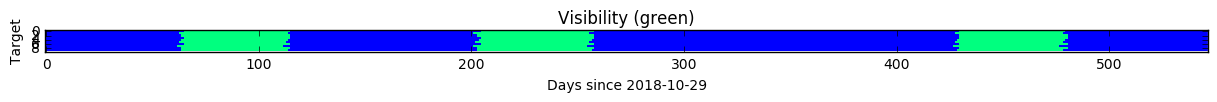

In [68]:
# Run through visibility_checker and check to see that the neighborhood is clear of other objects 
anim = ac.analyze_catalog(destination+name, None, lite=True, kind='')

# Plot the availability over the year
avail_data = np.load(destination+name+'_avail.npy')
plt.figure(figsize=(15,10))
plt.imshow(avail_data, cmap=cm.winter, interpolation='none')
plt.xlabel('Days since 2018-10-29')
plt.ylabel('Target')
plt.title('Visibility (green)')

As expected given our search radius, our K-giants are visible all at the same time, shown in green.

With target lists having scattered viewing times, we would want to sort our targets based on their visibility. For this example, we expect no difference after sorting since the targets all have similar viewing conditions. 

Still, let's run it just so we cover all the steps.

In [69]:
#!python sort_targets.py ./target_lists/AMI ./target_lists/AMI_avail.npy --min_per_day_hemi=4 --max_length=8

Next we will vet the list of candidates by searching the catalogs for binarity (Washington Double Star and Speckle), parallaxes (Gaia and Hipparchos), spectral types (Skiff, SEGUE, Michigan Spetral Survey), and allWISE magnitudes.

With these values, we can calculate the angular diameter and NIR-MIR colors of each candidate.

In [102]:
final = tt.vet_list(result, write_to='../ami_find_calibrators/{}_calibrators_{}deg.txt'.format(name,int(search_radius)))

Binary at 187.52, -13.39307. Skipping...

Done! 9 candidates found.

  SIMBAD      RA       Dec     J    H    K   qual   sep      SpT      d    theta_D   W1    W2       2MASS      
             deg       deg                         arcmin             pc   marcsec                             
--------- --------- --------- ---- ---- ---- ---- ------- --------- ------ ------- ----- ----- ----------------
HD 109181 188.22531 -16.66011 5.81 5.36 5.22  AAA  30.303    K0 III 214.13  0.8749 5.188 5.059 12325407-1639364
HD 108654  187.2677 -16.39214 6.08 5.49 5.34  AAA  44.762  K0/1 III 185.53  1.0097 5.306 5.253 12290424-1623317
HD 109709 189.21164 -15.57236 5.61 5.08 4.91  AAA   78.41    K0 III 390.62  0.4796 4.805 4.652 12365079-1534204
HD 110212 190.17918 -16.14674 6.14 5.43 5.22  AAA 124.597    K3 III 833.33  0.3443 5.189 5.108 12404300-1608482
HD 108216 186.49748 -17.92902 5.68 5.01 4.79  AAA 135.698    K3 III 377.36  0.7604 4.688 4.509 12255939-1755444
HD 109131  188.1331 -18.74577 5.98 


Table written to ../ami_find_calibrators/EtaCrv_calibrators_3deg.txt


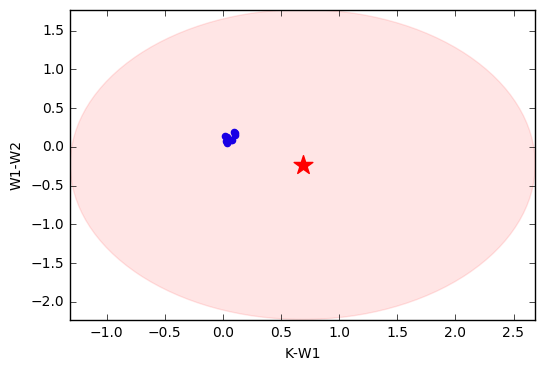

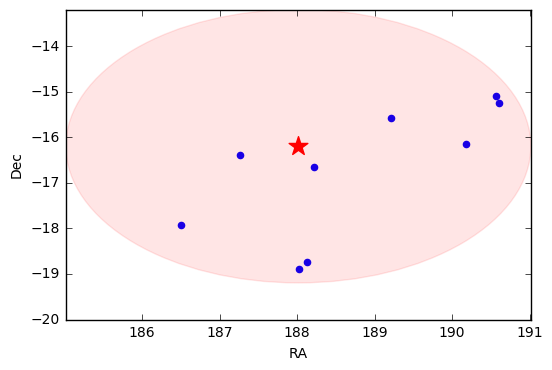

In [103]:
# Make a color color plot
tt.proximity_plot(final['K']-final['W1'], final['W1']-final['W2'], (K-W1,W1-W2), delta_color, 'K-W1', 'W1-W2')

# Make a skyplot
tt.proximity_plot(final['RA'], final['Dec'], (ra,dec), search_radius, 'RA', 'Dec')

FIN